In [1]:
import sqlite3
import pandas as pd
import os
import sys
import importlib

from pathlib import Path

# Add the Analytics_app directory to the Python path
root_dir = Path.cwd().parent.parent.parent
sys.path.append(str(root_dir / "Analytics_app"))

# Import the Ball_by_Ball class with reload to get latest changes
import data_cleaner
importlib.reload(data_cleaner)
from data_cleaner import Ball_by_Ball

data_dir = root_dir/"All data"/"T20_by_countries"/"Nepal"/"Database"

In [2]:
conn = sqlite3.connect(data_dir/'nepal_cricket.db')
cursor = conn.cursor()

# Initialize the Ball_by_Ball class with database connection for filtering
# Using dummy dataframe but passing the connection for filter operations
dummy_df = pd.DataFrame()
ball_processor = Ball_by_Ball(dummy_df, connection=conn)

In [3]:
# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables = [t[0] for t in tables]  # flatten
print(tables)

['male_ball_by_ball', 'sqlite_sequence', 'female_ball_by_ball', 'processing_summary', 'countries', 'teams', 'tournaments', 'umpires', 'players', 'matches']


In [4]:

import pandas as pd

cursor.execute("""
    SELECT *
    FROM matches
    WHERE strftime('%Y', date) = '2025'
      AND (winner_name = '' OR winner_name IS NULL)
""")

rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

df = pd.DataFrame(rows, columns=columns)
df

,id,match_id,date,match_format,comments,team_1_name,team_2_name,winner_name,host_country_name,venue_name,...,margin_type,toss_winner_name,toss_decision,tournament_name,season,gender,player_of_match,source_file,created_at,updated_at
0,147,3137,2025-04-12,T20,Quadrangular Twenty20 Series (Hong Kong),Hong Kong,Nepal,None,Hong Kong,"Mission Road Ground, Mong Kok, Hong Kong",...,None,Nepal,field,Quadrangular Twenty20 Series (Hong Kong),2025,male,[],1479325.json,2025-11-22 04:14:24,2025-11-22 04:14:24
1,154,3243,2025-06-16,T20,Scotland T20 Tri-Series,Netherlands,Nepal,None,Glasgow,"Titwood, Glasgow",...,None,Nepal,field,Scotland T20 Tri-Series,2025,male,['ZB Lion-Cachet'],1485939.json,2025-11-22 04:14:24,2025-11-22 04:14:24


In [5]:
# From 16 games , there all 11 games wih run out 

Only looking at the male tournament in 2025 and 2024

In [6]:
# Use Ball_by_Ball filter class to get data for 2025 and 2024
df_2025 = ball_processor.filter.by_year('2025')
df_2024 = ball_processor.filter.by_year('2024')

# Alternative: Get both years in one query
# df_both_years = ball_processor.filter.by_years(['2024', '2025'])

print(f"2025 data shape: {df_2025.shape}")
print(f"2024 data shape: {df_2024.shape}")

2025 data shape: (3926, 33)
2024 data shape: (5632, 33)


In [7]:
# Apply filter by innings_number to get Nepal batting data and opponents batting data
team_of_interest = 'Nepal'

# Use the is_team_batting method from our Ball_by_Ball class (already initialized above)
df_2025_nepal_bat = df_2025[df_2025.apply(lambda row: ball_processor.clean.is_team_batting(team_of_interest, row), axis=1)]
df_2025_others_bat = df_2025[~df_2025.apply(lambda row: ball_processor.clean.is_team_batting(team_of_interest, row), axis=1)]

# Optional: reset index
df_2025_nepal_bat = df_2025_nepal_bat.reset_index(drop=True)
df_2025_others_bat = df_2025_others_bat.reset_index(drop=True)

print(f"Nepal batting shape: {df_2025_nepal_bat.shape}")
print(f"Others batting shape: {df_2025_others_bat.shape}")

# Alternative: Use filter directly for team-specific data
# df_nepal_matches = ball_processor.filter.by_team('Nepal', years='2025')

Nepal batting shape: (1940, 33)
Others batting shape: (1986, 33)


In [8]:
# Apply filter by innings_number to get Nepal batting data and opponents batting data
team_of_interest = 'Nepal'

# Use the is_team_batting method from our Ball_by_Ball class (already initialized above)
df_2024_nepal_bat = df_2024[df_2024.apply(lambda row: ball_processor.clean.is_team_batting(team_of_interest, row), axis=1)]
df_2024_others_bat = df_2024[~df_2024.apply(lambda row: ball_processor.clean.is_team_batting(team_of_interest, row), axis=1)]

# Optional: reset index
df_2024_nepal_bat = df_2024_nepal_bat.reset_index(drop=True)
df_2024_others_bat = df_2024_others_bat.reset_index(drop=True)

print(f"Nepal batting shape: {df_2024_nepal_bat.shape}")
print(f"Others batting shape: {df_2024_others_bat.shape}")

Nepal batting shape: (2755, 33)
Others batting shape: (2877, 33)


In [9]:
# get all run out dismissals for others when Nepal bowling in 2025
df_2025_nepal_runouts = df_2025_others_bat[df_2025_others_bat['dismissal_type'] == 'run out']
print(f"Nepal run outs in 2025 shape: {df_2025_nepal_runouts.shape}")

Nepal run outs in 2025 shape: (16, 33)


In [10]:
# Nepal run out matches count
print(df_2025_nepal_runouts['cricinfo_match_id'].value_counts())
print(len(df_2025_nepal_runouts['cricinfo_match_id'].unique()))

cricinfo_match_id
1503460    3
1489968    2
1503457    2
1503463    2
1479322    1
1479327    1
1485940    1
1485941    1
1503452    1
1503466    1
1503470    1
Name: count, dtype: int64
11


In [11]:
(11/16)*100


68.75

In [12]:
df_2025_nepal_runouts['fielder'] = (
    df_2025_nepal_runouts['fielder']
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
)

df_2025_nepal_runouts['fielder']
df_2025_nepal_runouts[['fielder_1', 'fielder_2']] = (
    df_2025_nepal_runouts['fielder'].str.split(',', n=1, expand=True)
)

/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/656620792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025_nepal_runouts['fielder'] = (
/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/656620792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025_nepal_runouts[['fielder_1', 'fielder_2']] = (
/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/656620792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [13]:
df_2025_nepal_runouts['fielder_1'] = (df_2025_nepal_runouts['fielder_1'].str.replace('"', '').str.strip())

# if wkt is defined then fielder_2 to always be wkt, field 1 will be the keeper

df_2025_nepal_runouts['fielder_2'] = (
    df_2025_nepal_runouts['fielder_2'].str.replace('"', '').str.strip())

# define wicket_keeper
wicketkeepers = ['Aasif Sheikh', 'AK Sah']

def fix_keeper_order(row):
    f1, f2 = row['fielder_1'], row['fielder_2']

    # If f1 is a keeper → swap
    if f1 in wicketkeepers:
        return pd.Series([f2, f1])

    # If f2 is keeper → keep as is
    return pd.Series([f1, f2])

df_2025_nepal_runouts[['fielder_1', 'fielder_2']] = (
    df_2025_nepal_runouts.apply(fix_keeper_order, axis=1)
)




/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/1252582859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025_nepal_runouts['fielder_1'] = (df_2025_nepal_runouts['fielder_1'].str.replace('"', '').str.strip())
/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/1252582859.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025_nepal_runouts['fielder_2'] = (
/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/1252582859.py:21: SettingWithCopyWarning: 
A 

In [14]:
# in runout_counts_2025, if fielder_1 and 2 both have values, new column 'type' = 'assisted', else 'direct'
df_2025_nepal_runouts['type'] = df_2025_nepal_runouts.apply(
    lambda row: 'assisted' if pd.notna(row['fielder_2']) else 'direct-hit', axis=1
)

/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/2098291043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025_nepal_runouts['type'] = df_2025_nepal_runouts.apply(


In [15]:
df_2025_nepal_runouts.columns

Index(['id', 'match_id', 'cricinfo_match_id', 'innings_number', 'over_number',
       'ball_in_over', 'batsman', 'bowler', 'non_striker', 'fielder',
       'runs_batter', 'runs_extras', 'runs_total', 'is_wide', 'is_no_ball',
       'is_bye', 'is_leg_bye', 'is_legal_delivery', 'is_wicket',
       'dismissal_type', 'wicket_player_out', 'is_caught', 'ball_area',
       'shot_area', 'is_drs', 'is_umpires_call', 'milestone_type',
       'description', 'date', 'team_1_name', 'team_2_name', 'toss_winner_name',
       'toss_decision', 'fielder_1', 'fielder_2', 'type'],
      dtype='object')

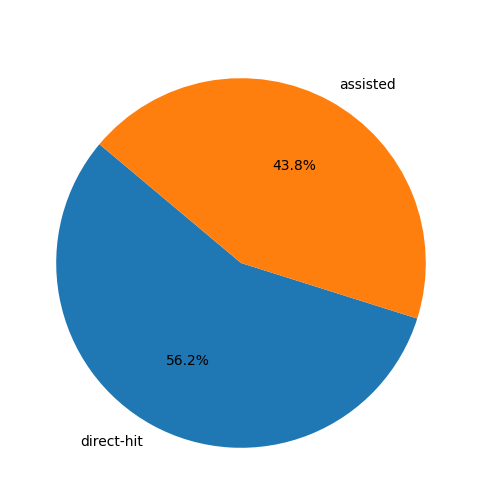

In [16]:
# seaborn plot assisted vs direct run outs (pie)
import seaborn as sns
import matplotlib.pyplot as plt
type_counts = df_2025_nepal_runouts['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Run Out Types by Nepal Fielders in 2025', color='white')
plt.savefig("/Users/saral/Documents/cricket/cricket_gardens/Articles/Nepal and run outs/output/runout_types_pie_chart.png", 
            transparent=True, dpi=300, bbox_inches='tight')
plt.show()

In [17]:
type_counts

type
direct-hit    9
assisted      7
Name: count, dtype: int64

In [18]:
# which player involved in direct runout
df_2025_nepal_runouts.groupby('type')['fielder_1'].value_counts()


type        fielder_1          
assisted    RK Paudel              2
            DS Airee               1
            K Bhurtel              1
            Lokesh Bam             1
            NK Yadav               1
            S Jora                 1
direct-hit  DS Airee               5
            K Bhurtel              1
            Karan KC               1
            Mohammad Aadil Alam    1
            RK Paudel              1
Name: count, dtype: int64

In [21]:
plot_df

type,direct-hit,assisted
fielder_1,,
DS Airee,5,1
K Bhurtel,1,1
Karan KC,1,0
Lokesh Bam,0,1
Mohammad Aadil Alam,1,0
NK Yadav,0,1
RK Paudel,1,2
S Jora,0,1
total,9,7


<Figure size 1000x600 with 0 Axes>

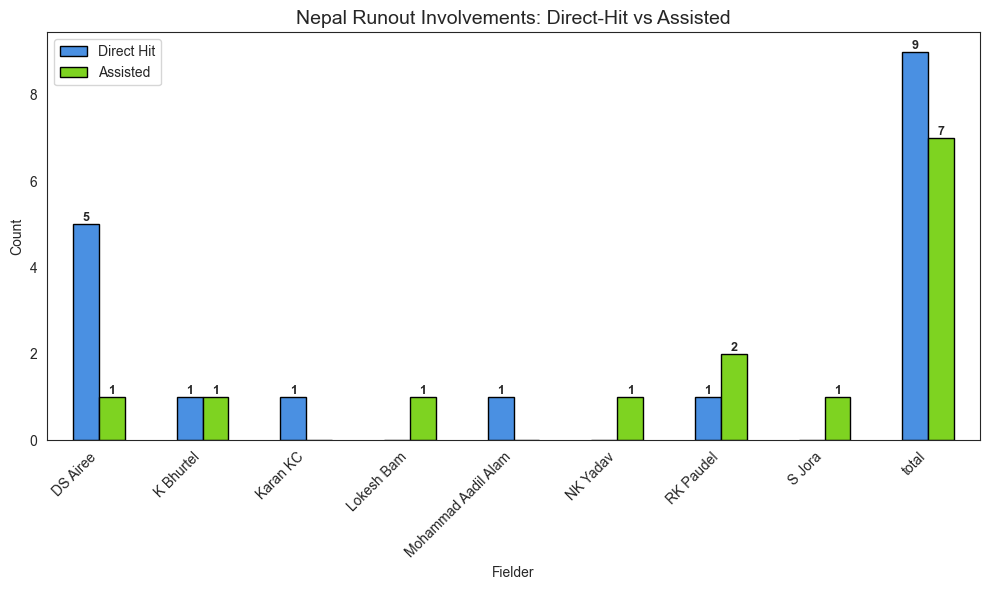

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your grouped results
grouped = df_2025_nepal_runouts.groupby('type')['fielder_1'].value_counts()

# Convert to dataframe
plot_df = grouped.unstack(fill_value=0)

# Ensure consistent column order (if both exist)
if 'direct-hit' in plot_df.columns and 'assisted' in plot_df.columns:
    plot_df = plot_df[['direct-hit', 'assisted']]

# Sort by total involvement
plot_df['total'] = plot_df.sum(axis=1)
plot_df = plot_df.sort_values(by='total', ascending=False)

# Transpose for your preferred fielder orientation
plot_df = plot_df.T

# Plot
plt.figure(figsize=(10, 6))

# Remove seaborn grid
sns.set_style("white")

ax = plot_df.plot(
    kind='bar',
    figsize=(10,6),
    color=['#4A90E2', '#7ED321'],
    edgecolor='black'
)

plt.title("Nepal Runout Involvements: Direct-Hit vs Assisted", fontsize=14)
plt.ylabel("Count")
plt.xlabel("Fielder")
plt.xticks(rotation=45, ha='right')
plt.legend(['Direct Hit', 'Assisted'])
plt.tight_layout()

# ---- Add annotations on top of each bar ----
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{int(height)}', 
            (p.get_x() + p.get_width()/2., height),
            ha='center', va='bottom', fontsize=9, fontweight='bold'
        )
plt.savefig("/Users/saral/Documents/cricket/cricket_gardens/Articles/Nepal and run outs/output/run_out_by_player.png", 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()


In [22]:
# run outs against which teams
df_2025_nepal_runouts.groupby('batsman')['fielder_1'].value_counts()


batsman             fielder_1          
Aamir Kaleem        DS Airee               1
Bilal Tahir         K Bhurtel              1
CV Anto             DS Airee               1
D Parashar          DS Airee               1
F Suluoto           Karan KC               1
Haider Ali          S Jora                 1
Junaid Siddique     RK Paudel              1
K Kadowaki-Fleming  DS Airee               1
KR Mayers           K Bhurtel              1
KU Carty            DS Airee               1
LR Naylor           Lokesh Bam             1
M Levitt            RK Paudel              1
MM Baig             DS Airee               1
MNM Aslam           NK Yadav               1
R Sakurano-Thomas   RK Paudel              1
Zubair Ali          Mohammad Aadil Alam    1
Name: count, dtype: int64

In [24]:
df_2025_nepal_runouts.groupby('cricinfo_match_id').value_counts()


cricinfo_match_id  id     match_id  innings_number  over_number  ball_in_over  batsman            bowler     non_striker    fielder                      runs_batter  runs_extras  runs_total  is_wide  is_no_ball  is_bye  is_leg_bye  is_legal_delivery  is_wicket  dismissal_type  wicket_player_out  is_caught  ball_area  shot_area  is_drs  is_umpires_call  milestone_type  description  date        team_1_name  team_2_name           toss_winner_name  toss_decision  fielder_1   fielder_2     type    
1479322            18715  3134      1               20           6             MNM Aslam          NK Yadav   Yasin Patel    "Aasif Sheikh", "NK Yadav"   0            2            2           0        0           1       0           1                  1          run out         MNM Aslam          0                                0       0                                             2025-04-10  Kuwait       Nepal                 Nepal             field          NK Yadav    Aasif Sheikh  assisted   

In [31]:
run_out_by_matches = df_2025_nepal_runouts.groupby(
    ['over_number','batsman', 'team_1_name', 'team_2_name','cricinfo_match_id']
)['fielder_1'].value_counts()

In [32]:
run_out_by_matches = pd.DataFrame(run_out_by_matches).reset_index()
run_out_by_matches

,over_number,batsman,team_1_name,team_2_name,cricinfo_match_id,fielder_1,count
0,2,KR Mayers,Nepal,West Indies,1489968,K Bhurtel,1
1,2,LR Naylor,Scotland,Nepal,1485940,Lokesh Bam,1
2,4,K Kadowaki-Fleming,Japan,Nepal,1503457,DS Airee,1
3,6,Aamir Kaleem,Nepal,Oman,1503466,DS Airee,1
4,6,M Levitt,Netherlands,Nepal,1485941,RK Paudel,1
5,10,CV Anto,Nepal,Kuwait,1503452,DS Airee,1
6,13,KU Carty,Nepal,West Indies,1489968,DS Airee,1
7,14,MM Baig,Nepal,Qatar,1503463,DS Airee,1
8,14,Zubair Ali,Nepal,Qatar,1503463,Mohammad Aadil Alam,1
9,15,Bilal Tahir,Kuwait,Nepal,1479327,K Bhurtel,1


In [33]:
run_out_by_matches.loc[0, 'batting_order'] = 4 # Aamir Kaleem of his own bowling DSairee
run_out_by_matches.loc[1, 'batting_order'] = 6 # Bilal Tahir 
run_out_by_matches.loc[2, 'batting_order'] = 1 # CV Anto	of his own bowling 
run_out_by_matches.loc[3, 'batting_order'] = 4 # R Chopra
run_out_by_matches.loc[4, 'batting_order'] = 7 # F Suloto
run_out_by_matches.loc[5, 'batting_order'] = 8 # Haider ali
run_out_by_matches.loc[6, 'batting_order'] = 9 # Zaid Ali
run_out_by_matches.loc[7, 'batting_order'] = 2 # Abhishek Anand
run_out_by_matches.loc[8, 'batting_order'] = 1 # 
run_out_by_matches.loc[9, 'batting_order'] = 5 # 
run_out_by_matches.loc[10, 'batting_order'] = 4 # LR Nalor
run_out_by_matches.loc[11, 'batting_order'] = 5 # M Levitt
run_out_by_matches.loc[12, 'batting_order'] = 4 # MM Baig
run_out_by_matches.loc[13, 'batting_order'] = 4 # 
run_out_by_matches.loc[14, 'batting_order'] = 7 # 
run_out_by_matches.loc[15, 'batting_order'] = 5 # 

run_out_by_matches


,over_number,batsman,team_1_name,team_2_name,cricinfo_match_id,fielder_1,count,batting_order
0,2,KR Mayers,Nepal,West Indies,1489968,K Bhurtel,1,4.0
1,2,LR Naylor,Scotland,Nepal,1485940,Lokesh Bam,1,6.0
2,4,K Kadowaki-Fleming,Japan,Nepal,1503457,DS Airee,1,1.0
3,6,Aamir Kaleem,Nepal,Oman,1503466,DS Airee,1,4.0
4,6,M Levitt,Netherlands,Nepal,1485941,RK Paudel,1,7.0
5,10,CV Anto,Nepal,Kuwait,1503452,DS Airee,1,8.0
6,13,KU Carty,Nepal,West Indies,1489968,DS Airee,1,9.0
7,14,MM Baig,Nepal,Qatar,1503463,DS Airee,1,2.0
8,14,Zubair Ali,Nepal,Qatar,1503463,Mohammad Aadil Alam,1,1.0
9,15,Bilal Tahir,Kuwait,Nepal,1479327,K Bhurtel,1,5.0


In [34]:
def categorize_order(pos):
    if 1 <= pos <= 3:
        return "Top Order"
    elif 4 <= pos <= 6:
        return "Middle Order"
    elif 7 <= pos <= 8:
        return "Lower Middle Order"
    elif 9 <= pos <= 11:
        return "Lower Order"
    else:
        return "Unknown"
        

        
run_out_by_matches['order_group'] = run_out_by_matches['batting_order'].apply(categorize_order)

# Run out by batting order


In [35]:
def overs_order(overs):
    if 0 <= overs < 6:
        return "Powerplay"
    elif 6 <= overs <= 15:
        return "Middle Overs"
    elif overs > 15:
        return "Death Overs"
    else:
        return "Unknown"
    
run_out_by_matches['bowling_overs'] = run_out_by_matches['over_number'].apply(overs_order)

In [36]:
order_counts = run_out_by_matches['order_group'].value_counts()
order_counts


order_group
Middle Order          9
Top Order             3
Lower Middle Order    3
Lower Order           1
Name: count, dtype: int64

In [39]:
run_out_by_matches.to_excel("/Users/saral/Documents/cricket/cricket_gardens/Articles/Nepal and run outs/data_for_tableau/run_out_by_matches_2025.xlsx", index=False)

/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/376639307.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_50422/376639307.py:5: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


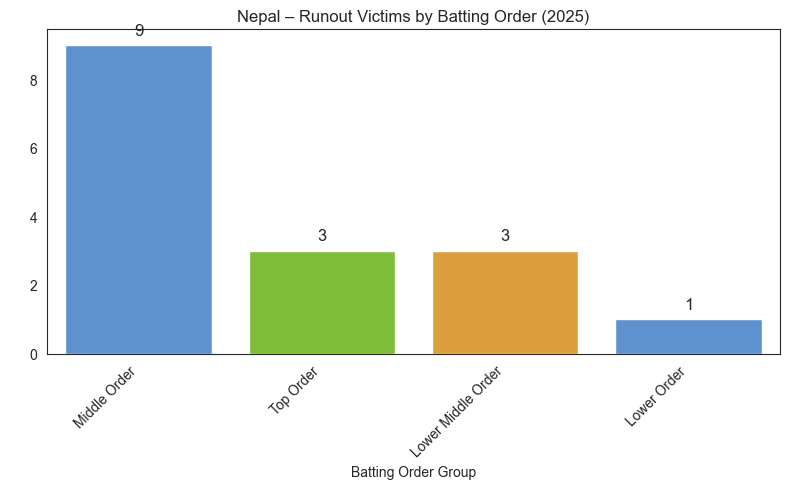

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    x=order_counts.index,
    y=order_counts.values,
    palette=["#4A90E2", "#7ED321", "#F5A623"]  # Top/Middle/Lower colors
)

plt.title("Nepal – Runout Victims by Batting Order (2025)")
plt.xlabel("Batting Order Group")
plt.ylabel("Runouts", color = 'white')
plt.xticks(rotation=45, ha='right')


# Add value labels
for i, val in enumerate(order_counts.values):
    plt.text(i, val + 0.3, str(val), ha='center', fontsize=12)
plt.savefig("/Users/saral/Documents/cricket/cricket_gardens/Articles/Nepal and run outs/output/run_out_by_player_order.png", 
            transparent=True, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [270]:
# 17 games in 2025, 11 games have run out .
(11/17)*100

64.70588235294117

In [271]:
# total wickets in 2025
df_2025_others_bat['is_wicket'].sum()

np.int64(128)

In [272]:
# only wickets 
df_2025_others_bat_only_wickets = df_2025_others_bat[df_2025_others_bat['is_wicket'] == 1]
df_2025_others_bat_only_wickets['dismissal_type'].value_counts()

dismissal_type
caught               67
bowled               29
run out              16
lbw                   8
stumped               4
caught and bowled     3
hit wicket            1
Name: count, dtype: int64

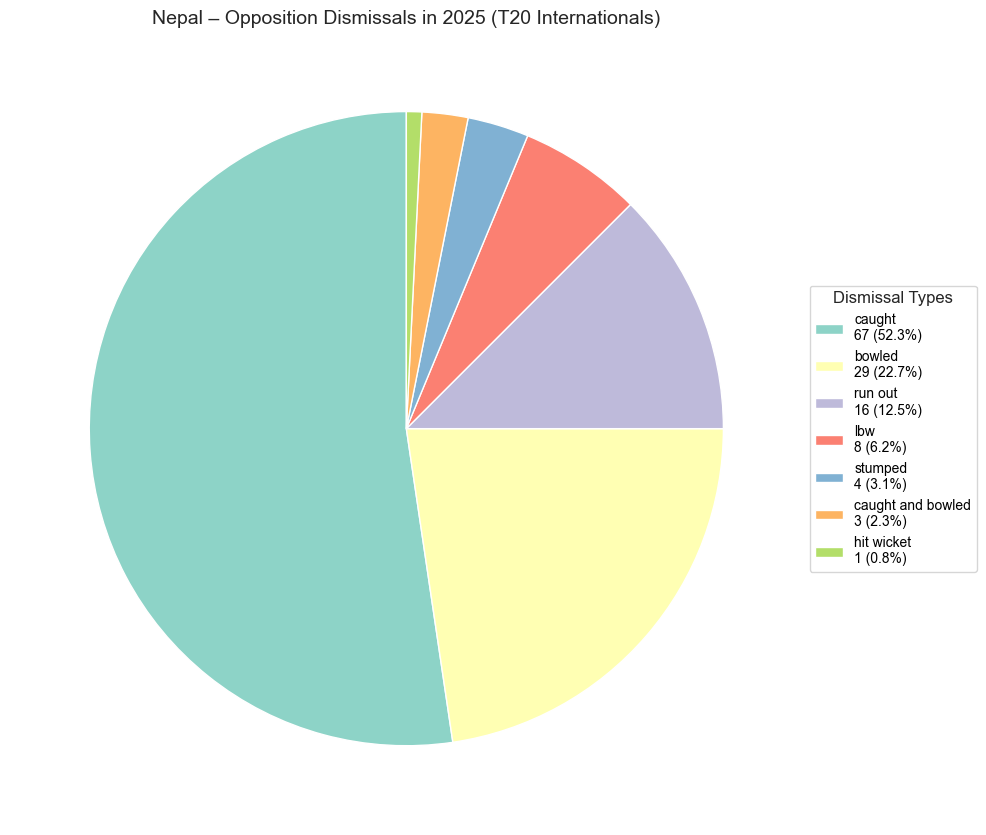

In [273]:
import matplotlib.pyplot as plt

# dismissal counts
dismissal_counts = df_2025_others_bat_only_wickets['dismissal_type'].value_counts()

# labels with counts + %
labels = [
    f"{label}\n{count} ({count / dismissal_counts.sum() * 100:.1f}%)"
    for label, count in dismissal_counts.items()
]

colors = plt.cm.Set3(range(len(dismissal_counts)))   # pleasant color palette

plt.figure(figsize=(10, 10))
wedges, texts = plt.pie(
    dismissal_counts,
    colors=colors,
    startangle=90,
    wedgeprops={"linewidth": 1, "edgecolor": "white"}
)

# Add labels outside with lines
legend = plt.legend(
    wedges,
    labels,
    title="Dismissal Types",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

# Set legend text color to white
# legend.get_title().set_color('white')
for text in legend.get_texts():
    text.set_color('black')

plt.title("Nepal – Opposition Dismissals in 2025 (T20 Internationals)", fontsize=14)

plt.tight_layout()
plt.savefig("/Users/saral/Documents/cricket/cricket_gardens/Articles/Nepal and run outs/output/dismissal_type.png", 
            transparent=True, dpi=300, bbox_inches='tight')
plt.show()

In [274]:
# the matches with run outs cricinfo_ids, and the match
df_2025_nepal_runouts['cricinfo_match_id'].unique()

array(['1479322', '1479327', '1485940', '1485941', '1489968', '1503452',
       '1503457', '1503460', '1503463', '1503466', '1503470'],
      dtype=object)

In [275]:
df_match_id_run_outs = pd.DataFrame(df_2025_nepal_runouts['cricinfo_match_id'].unique())
df_match_id_run_outs

,0
0,1479322
1,1479327
2,1485940
3,1485941
4,1489968
5,1503452
6,1503457
7,1503460
8,1503463
9,1503466


In [276]:
# all matches

import pandas as pd

cursor.execute("""
    SELECT *
    FROM matches
    WHERE strftime('%Y', date) = '2025'
      AND gender = 'male'
""")

rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

df = pd.DataFrame(rows, columns=columns)
df

,id,match_id,date,match_format,comments,team_1_name,team_2_name,winner_name,host_country_name,venue_name,...,margin_type,toss_winner_name,toss_decision,tournament_name,season,gender,player_of_match,source_file,created_at,updated_at
0,145,3131,2025-04-09,T20,Quadrangular Twenty20 Series (Hong Kong),Qatar,Nepal,Nepal,Hong Kong,"Mission Road Ground, Mong Kok, Hong Kong",...,wkts,Nepal,field,Quadrangular Twenty20 Series (Hong Kong),2025,male,['K Bhurtel'],1479320.json,2025-11-22 04:14:24,2025-11-22 04:14:24
1,146,3134,2025-04-10,T20,Quadrangular Twenty20 Series (Hong Kong),Kuwait,Nepal,Nepal,Hong Kong,"Mission Road Ground, Mong Kok, Hong Kong",...,wkts,Nepal,field,Quadrangular Twenty20 Series (Hong Kong),2025,male,['K Bhurtel'],1479322.json,2025-11-22 04:14:24,2025-11-22 04:14:24
2,147,3137,2025-04-12,T20,Quadrangular Twenty20 Series (Hong Kong),Hong Kong,Nepal,None,Hong Kong,"Mission Road Ground, Mong Kok, Hong Kong",...,None,Nepal,field,Quadrangular Twenty20 Series (Hong Kong),2025,male,[],1479325.json,2025-11-22 04:14:24,2025-11-22 04:14:24
3,148,3193,2025-04-13,T20,Quadrangular Twenty20 Series (Hong Kong),Kuwait,Nepal,Kuwait,Hong Kong,"Mission Road Ground, Mong Kok, Hong Kong",...,runs,Nepal,field,Quadrangular Twenty20 Series (Hong Kong),2025,male,['A Chenthamara'],1479327.json,2025-11-22 04:14:24,2025-11-22 04:14:24
4,154,3243,2025-06-16,T20,Scotland T20 Tri-Series,Netherlands,Nepal,None,Glasgow,"Titwood, Glasgow",...,None,Nepal,field,Scotland T20 Tri-Series,2025,male,['ZB Lion-Cachet'],1485939.json,2025-11-22 04:14:24,2025-11-22 04:14:24
5,155,3246,2025-06-17,T20,Scotland T20 Tri-Series,Scotland,Nepal,Nepal,Glasgow,"Titwood, Glasgow",...,wkts,Nepal,field,Scotland T20 Tri-Series,2025,male,['S Lamichhane'],1485940.json,2025-11-22 04:14:24,2025-11-22 04:14:24
6,156,3250,2025-06-19,T20,Scotland T20 Tri-Series,Netherlands,Nepal,Nepal,Glasgow,"Titwood, Glasgow",...,wkts,Nepal,field,Scotland T20 Tri-Series,2025,male,['M Levitt'],1485941.json,2025-11-22 04:14:24,2025-11-22 04:14:24
7,157,3253,2025-06-20,T20,Scotland T20 Tri-Series,Scotland,Nepal,Scotland,Glasgow,"Titwood, Glasgow",...,runs,Scotland,bat,Scotland T20 Tri-Series,2025,male,['HG Munsey'],1485943.json,2025-11-22 04:14:24,2025-11-22 04:14:24
8,158,3477,2025-09-27,T20,Nepal v West Indies T20I Series,Nepal,West Indies,Nepal,Sharjah Cricket Stadium,Sharjah Cricket Stadium,...,runs,West Indies,field,Nepal v West Indies T20I Series,2025,male,['RK Paudel'],1489968.json,2025-11-22 04:14:24,2025-11-22 04:14:24
9,159,3483,2025-09-29,T20,Nepal v West Indies T20I Series,Nepal,West Indies,Nepal,Sharjah Cricket Stadium,Sharjah Cricket Stadium,...,runs,Nepal,bat,Nepal v West Indies T20I Series,2025,male,['Aasif Sheikh'],1489969.json,2025-11-22 04:14:24,2025-11-22 04:14:24


In [277]:
# merge team_1_name, team_2_name, winner_name from df, and match_id of run out - df_match_id_run_outs
# First rename the column in df_match_id_run_outs to match the merge key
df_match_id_run_outs.columns = ['cricinfo_match_id']

# the source_file column has xxxxxxx.json , remove the .json and create cricinfo_match_id column in df
df['cricinfo_match_id'] = df['source_file'].str.replace('.json', '', regex=False)

# Merge to get match details for games with run outs
matches_with_runouts = pd.merge(
    df_match_id_run_outs,
    df[['cricinfo_match_id', 'team_1_name', 'team_2_name', 'winner_name', 'date']],
    on='cricinfo_match_id',
    how='left'
)

print(f"Matches with run outs: {len(matches_with_runouts)}")
matches_with_runouts

Matches with run outs: 11


,cricinfo_match_id,team_1_name,team_2_name,winner_name,date
0,1479322,Kuwait,Nepal,Nepal,2025-04-10
1,1479327,Kuwait,Nepal,Kuwait,2025-04-13
2,1485940,Scotland,Nepal,Nepal,2025-06-17
3,1485941,Netherlands,Nepal,Nepal,2025-06-19
4,1489968,Nepal,West Indies,Nepal,2025-09-27
5,1503452,Nepal,Kuwait,Nepal,2025-10-08
6,1503457,Japan,Nepal,Nepal,2025-10-10
7,1503460,Nepal,United Arab Emirates,Nepal,2025-10-12
8,1503463,Nepal,Qatar,Nepal,2025-10-13
9,1503466,Nepal,Oman,Nepal,2025-10-15


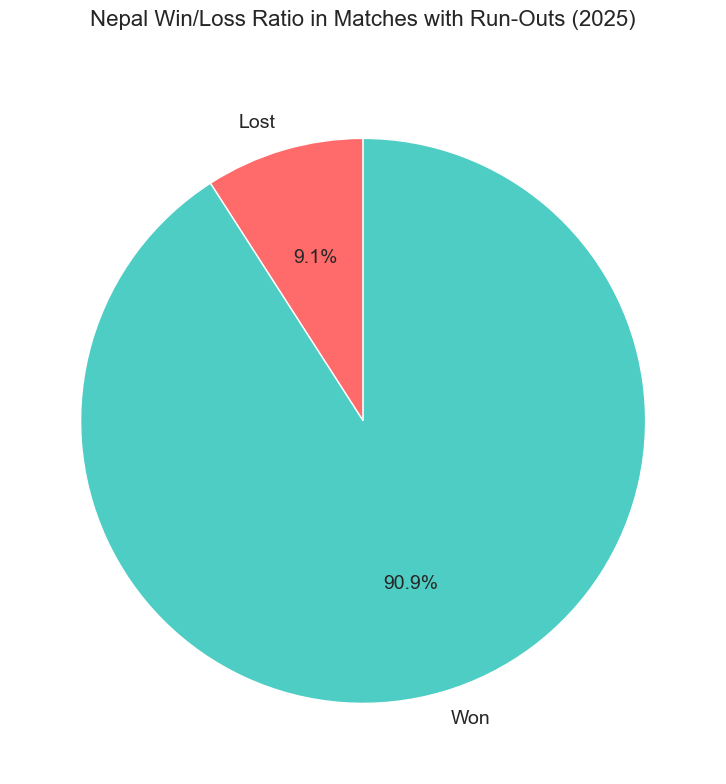

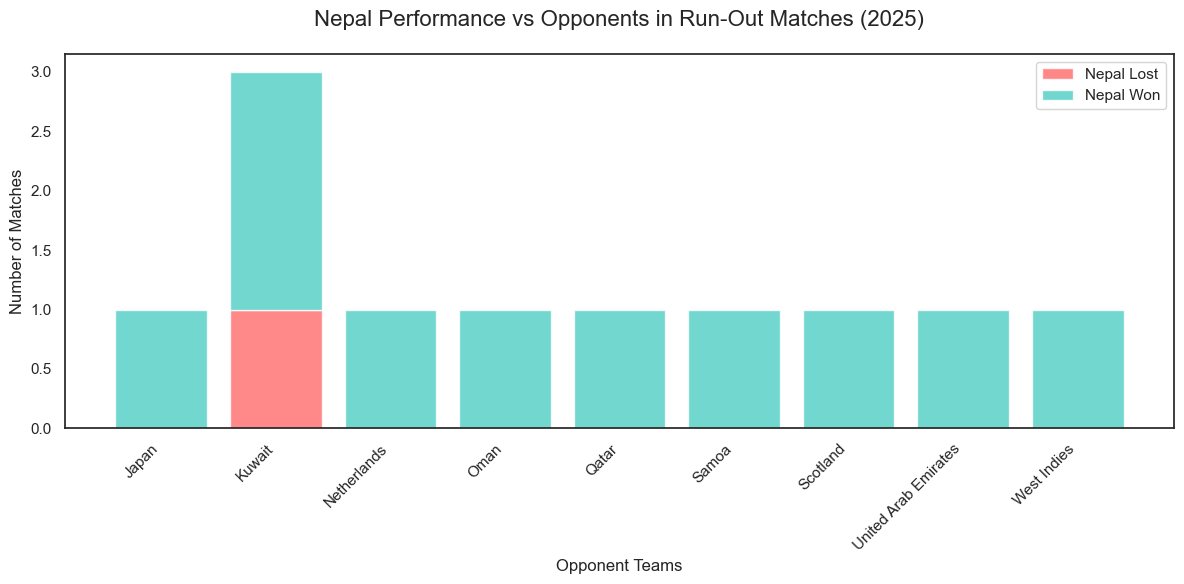


Summary Statistics:
Total matches with run-outs: 11
Nepal wins in run-out matches: 10
Nepal losses in run-out matches: 1
Nepal win rate in matches with run-outs: 90.9%

Opponent breakdown:
opponent
Kuwait                  3
Scotland                1
Netherlands             1
West Indies             1
Japan                   1
United Arab Emirates    1
Qatar                   1
Oman                    1
Samoa                   1
Name: count, dtype: int64


In [278]:
# lets visualize Nepal's win from matches_with_runouts
import matplotlib.pyplot as plt
import seaborn as sns

# Create a win/loss indicator for Nepal
matches_with_runouts['nepal_won'] = matches_with_runouts['winner_name'] == 'Nepal'

# Count wins vs losses in matches with run-outs
win_loss_counts = matches_with_runouts['nepal_won'].value_counts()
win_loss_labels = ['Lost', 'Won'] if False in win_loss_counts.index else ['Won']
win_loss_values = [win_loss_counts[False], win_loss_counts[True]] if False in win_loss_counts.index else [win_loss_counts[True]]

# IMAGE 1: Pie chart for win/loss ratio in run-out matches
plt.figure(figsize=(8, 8))
colors = ['#FF6B6B', '#4ECDC4'] if len(win_loss_values) == 2 else ['#4ECDC4']
wedges, texts, autotexts = plt.pie(
    win_loss_values, 
    labels=win_loss_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={ 'fontsize': 14}
)

plt.title('Nepal Win/Loss Ratio in Matches with Run-Outs (2025)', 
           fontsize=16, pad=30)

# Style the plot
plt.gca().set_facecolor('none')
plt.gcf().patch.set_facecolor('none')

plt.tight_layout()
plt.savefig("/Users/saral/Documents/cricket/cricket_gardens/Articles/Nepal and run outs/output/nepal_wins_pie_chart.png", 
            transparent=True, dpi=300, bbox_inches='tight', facecolor='none')
plt.show()

# IMAGE 2: Bar chart showing opponents in run-out matches with win/loss
opponent_wins = []
for _, row in matches_with_runouts.iterrows():
    if row['team_1_name'] == 'Nepal':
        opponent = row['team_2_name']
    else:
        opponent = row['team_1_name']
    opponent_wins.append({
        'opponent': opponent,
        'nepal_won': row['nepal_won']
    })

opponent_df = pd.DataFrame(opponent_wins)
opponent_summary = opponent_df.groupby(['opponent', 'nepal_won']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))

# Create stacked bar chart
if True in opponent_summary.columns and False in opponent_summary.columns:
    plt.bar(opponent_summary.index, opponent_summary[False], 
           label='Nepal Lost', color='#FF6B6B', alpha=0.8)
    plt.bar(opponent_summary.index, opponent_summary[True], 
           bottom=opponent_summary[False], label='Nepal Won', color='#4ECDC4', alpha=0.8)
elif True in opponent_summary.columns:
    plt.bar(opponent_summary.index, opponent_summary[True], 
           label='Nepal Won', color='#4ECDC4', alpha=0.8)
else:
    plt.bar(opponent_summary.index, opponent_summary[False], 
           label='Nepal Lost', color='#FF6B6B', alpha=0.8)

plt.title('Nepal Performance vs Opponents in Run-Out Matches (2025)', fontsize=16, pad=20)
plt.xlabel('Opponent Teams', fontsize=12)
plt.ylabel('Number of Matches',  fontsize=12)
# plt.tick_params(colors='white')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Style the plot
plt.gca().set_facecolor('none')
plt.gcf().patch.set_facecolor('none')

plt.tight_layout()
plt.savefig("/Users/saral/Documents/cricket/cricket_gardens/Articles/Nepal and run outs/output/nepal_vs_opponents_bar_chart.png", 
            transparent=True, dpi=300, bbox_inches='tight', facecolor='none')
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Total matches with run-outs: {len(matches_with_runouts)}")
print(f"Nepal wins in run-out matches: {sum(matches_with_runouts['nepal_won'])}")
print(f"Nepal losses in run-out matches: {sum(~matches_with_runouts['nepal_won'])}")
if len(matches_with_runouts) > 0:
    win_rate = (sum(matches_with_runouts['nepal_won']) / len(matches_with_runouts)) * 100
    print(f"Nepal win rate in matches with run-outs: {win_rate:.1f}%")

print(f"\nOpponent breakdown:")
print(opponent_df['opponent'].value_counts())